In [1]:
# import libraries
from cil.optimisation.algorithms import LADMM, PDHG
from cil.optimisation.functions import KullbackLeibler, WeightedL2NormSquared, MixedL21Norm, BlockFunction, IndicatorBox, TotalVariation
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator
from cil.framework import ImageGeometry, AcquisitionGeometry
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import show2D
from cil.plugins.ccpi_regularisation.functions import FGP_TV 

import matplotlib.pyplot as plt
import os, sys
import numpy as np

import tomophantom
from tomophantom import TomoP2D

In [2]:
# Load a tomophantom image 
model = 12 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.5, voxel_size_y = 0.5)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np)

In [3]:
# Create Acquisition Geometry
detectors =  int(np.sqrt(2)*N)
angles = np.linspace(0, np.pi, 90, dtype=np.float32)

ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles,angle_unit="radian")\
                        .set_panel(detectors, pixel_size=0.5)

In [4]:
device = "gpu"

In [5]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, device )

In [6]:
# Create projection data and corrupt with noise
np.random.seed(10)

data = A.direct(phantom2D)
noisy_data = ag.allocate()

eta = ag.allocate(5)
scale = 2
n1 = np.random.poisson( scale*(data.as_array() + eta.as_array()))/scale
noisy_data.fill(n1)

/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/utilities/display.py:298: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


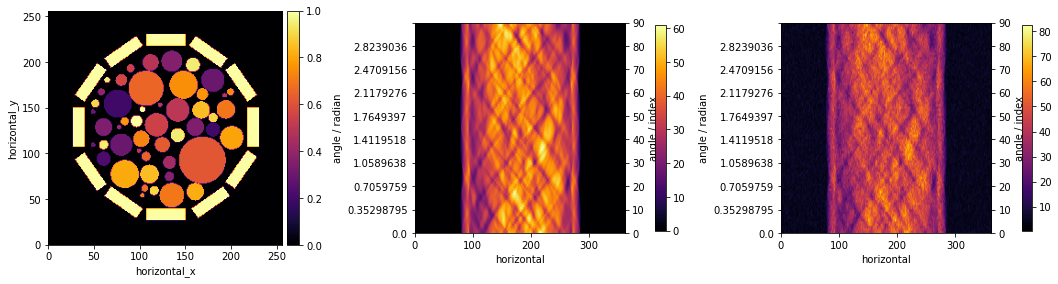

In [7]:
show2D([phantom2D, data, noisy_data], num_cols=3, cmap="inferno")

In [8]:
# Regularisation parameter
alpha = 0.5

In [9]:
# Setup and run ADMM  algorithm
Grad = GradientOperator(ig)
K = BlockOperator(Grad, A)
g = BlockFunction(alpha * MixedL21Norm(), KullbackLeibler(b=noisy_data,eta=eta))
f = IndicatorBox(lower=0.0)

normK = K.norm()
sigma = 1.
tau = sigma/normK**2

admm = LADMM(f=f, g=g, operator=K, sigma=sigma, tau=tau,
           max_iteration=1000, update_objective_interval=200)
admm.run(verbose=1)  

Initialised GradientOperator with C backend running with  20  threads
LADMM setting up
LADMM configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          9.61599e+05


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      200       1000         0.016          1.95310e+04
      400       1000         0.016          1.49099e+04
      600       1000         0.017          1.31817e+04
      800       1000         0.017          1.22566e+04
     1000       1000         0.017          1.16954e+04
-------------------------------------------------------
     1000       1000         0.017          1.16954e+04
Stop criterion has been reached.



In [10]:
# Setup and run PDHG implicit algorithm
sigma = 1.
tau = 1./(sigma*normK**2)
pdhg = PDHG(f=g, g=f, operator=K, sigma=sigma, tau=tau,
           max_iteration=1000, update_objective_interval=200)
pdhg.run(verbose=2)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0       1000         0.000    9.61599e+05  -0.00000e+00    9.61599e+05
      200       1000         0.019    1.95779e+04  -1.35596e+04    3.31375e+04
      400       1000         0.019    1.49223e+04   7.97953e+02    1.41243e+04
      600       1000         0.018    1.31878e+04   4.11473e+03    9.07304e+03
      800       1000         0.018    1.22601e+04   5.81292e+03    6.44722e+03
     1000       1000         0.018    1.16977e+04   6.87455e+03    4.82311e+03
----------------------------------------------------------------------------
     1000       1000         0.018    1.16977e+04   6.87455e+03    4.82311e+03
Stop criterion has been reached.



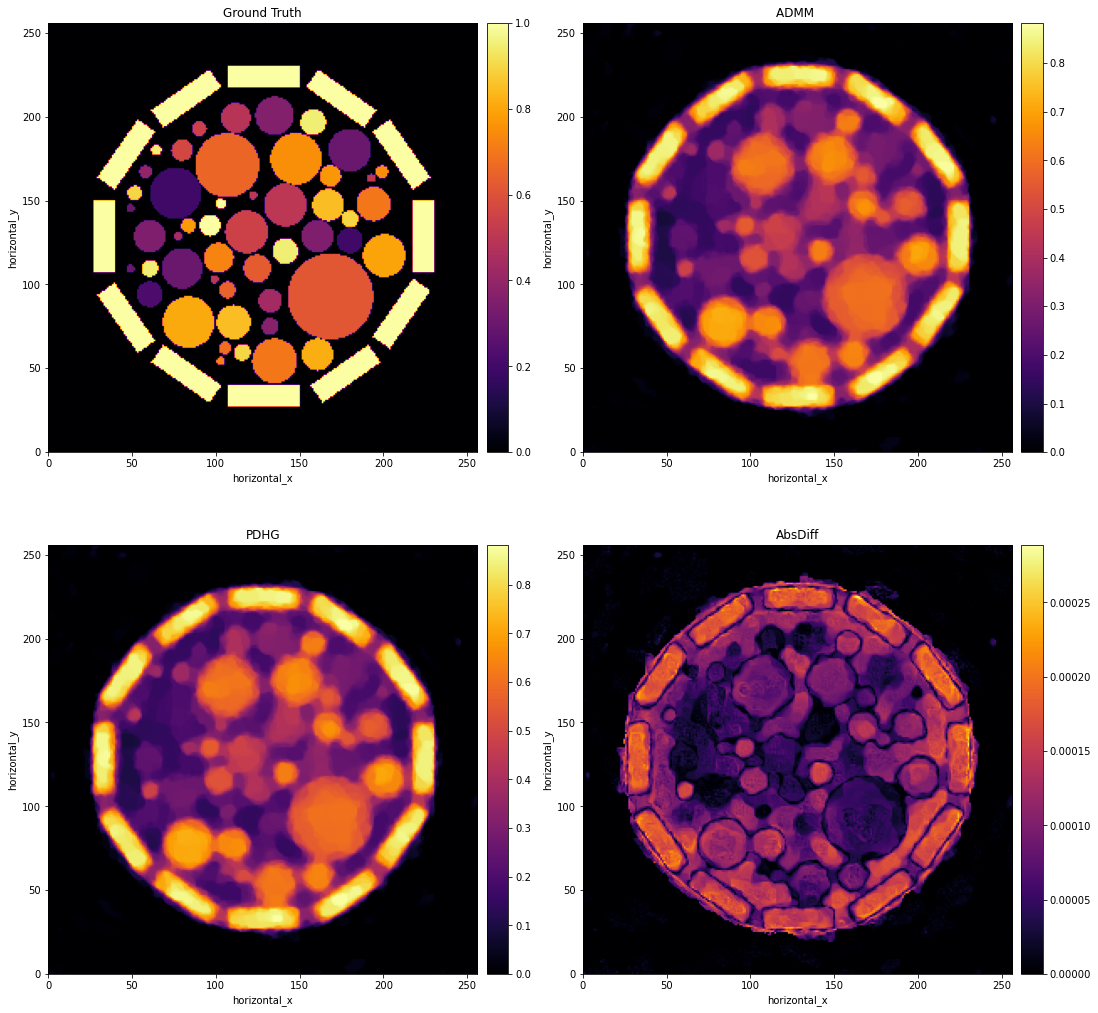

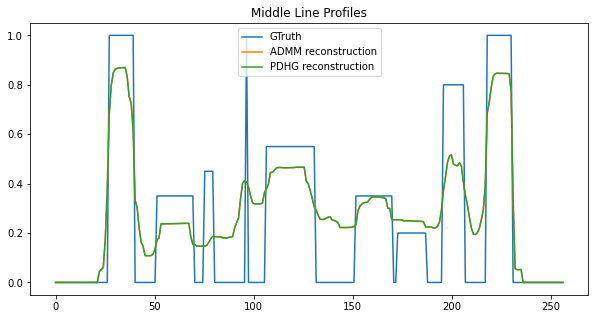

In [11]:
show2D([phantom2D, admm.solution, pdhg.solution, (admm.solution-pdhg.solution).abs()], 
       title=["Ground Truth", "ADMM ", "PDHG","AbsDiff"], cmap="inferno")

plt.figure(figsize=(10,5))            
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), phantom2D.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), admm.get_output().as_array()[int(ig.shape[0]/2),:], label = 'ADMM reconstruction')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), pdhg.get_output().as_array()[int(ig.shape[0]/2),:], label = 'PDHG reconstruction')

plt.legend()
plt.title('Middle Line Profiles')
plt.show()

In [12]:
# -*- coding: utf-8 -*-
#   This work is part of the Core Imaging Library (CIL) developed by CCPi 
#   (Collaborative Computational Project in Tomographic Imaging), with 
#   substantial contributions by UKRI-STFC and University of Manchester.

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

from cil.optimisation.algorithms import Algorithm
import warnings

class master_LADMM(Algorithm):
        
    ''' 
        LADMM is the Linearized Alternating Direction Method of Multipliers (LADMM)
    
        General form of ADMM : min_{x} f(x) + g(y), subject to Ax + By = b
    
        Case: A = Id, B = -K, b = 0   ==> min_x f(Kx) + g(x)  
                
        The quadratic term in the augmented Lagrangian is linearized for the x-update.
                            
        Main algorithmic difference is that in ADMM we compute two proximal subproblems, 
        where in the PDHG a proximal and proximal conjugate.

        Reference (Section 8) : https://link.springer.com/content/pdf/10.1007/s10107-018-1321-1.pdf                          

            x^{k} = prox_{\tau f } (x^{k-1} - tau/sigma A^{T}(Ax^{k-1} - z^{k-1} + u^{k-1} )                
            
            z^{k} = prox_{\sigma g} (Ax^{k} + u^{k-1})
            
            u^{k} = u^{k-1} + Ax^{k} - z^{k}
                
    '''

    def __init__(self, f=None, g=None, operator=None, \
                       tau = None, sigma = 1., 
                       initial = None, **kwargs):
        
        '''Initialisation of the algorithm

        :param operator: a Linear Operator
        :param f: Convex function with "simple" proximal
        :param g: Convex function with "simple" proximal 
        :param sigma: Positive step size parameter 
        :param tau: Positive step size parameter
        :param initial: Initial guess ( Default initial_guess = 0)'''        
        
        super(master_LADMM, self).__init__(**kwargs)
        if kwargs.get('x_init', None) is not None:
            if initial is None:
                warnings.warn('The use of the x_init parameter is deprecated and will be removed in following version. Use initial instead',
                   DeprecationWarning, stacklevel=4)
                initial = kwargs.get('x_init', None)
            else:
                raise ValueError('{} received both initial and the deprecated x_init parameter. It is not clear which one we should use.'\
                    .format(self.__class__.__name__))

        self.set_up(f = f, g = g, operator = operator, tau = tau,\
             sigma = sigma, initial=initial)        
                    
    def set_up(self, f, g, operator, tau = None, sigma=1., \
        initial=None):

        print("{} setting up".format(self.__class__.__name__, ))
        
        if sigma is None and tau is None:
            raise ValueError('Need tau <= sigma / ||K||^2')

        self.f = f
        self.g = g
        self.operator = operator

        self.tau = tau
        self.sigma = sigma

        if self.tau is None:
            normK = self.operator.norm()
            self.tau = self.sigma / normK ** 2
            
        if initial is None:
            self.x = self.operator.domain_geometry().allocate(0)
        else:
            self.x = initial.copy()
         
        # allocate space for operator direct & adjoint    
        self.tmp_dir = self.operator.direct(self.x) #self.operator.range_geometry().allocate()
        self.tmp_adj = self.operator.domain_geometry().allocate(0)            
            
        self.z = self.operator.range_geometry().allocate(0) 
        self.u = self.operator.range_geometry().allocate(0) 

        self.configured = True  
        
        print("{} configured".format(self.__class__.__name__, ))
        
    def update(self):
                        
        self.tmp_dir += self.u
        self.tmp_dir -= self.z          
        self.operator.adjoint(self.tmp_dir, out = self.tmp_adj) 
                                        
        self.tmp_adj *= -(self.tau/self.sigma)
        self.x += self.tmp_adj     
        
        # apply proximal of f        
        self.f.proximal(self.x, self.tau, out=self.x)
        self.operator.direct(self.x, out = self.tmp_dir)  
        
        # apply proximal of g   
        self.g.proximal(self.tmp_dir + self.u, self.sigma, out = self.z)

        # update 
        self.u += self.tmp_dir
        self.u -= self.z

    def update_objective(self):
        
        self.loss.append(self.f(self.x) +  self.g(self.operator.direct(self.x)) )                 

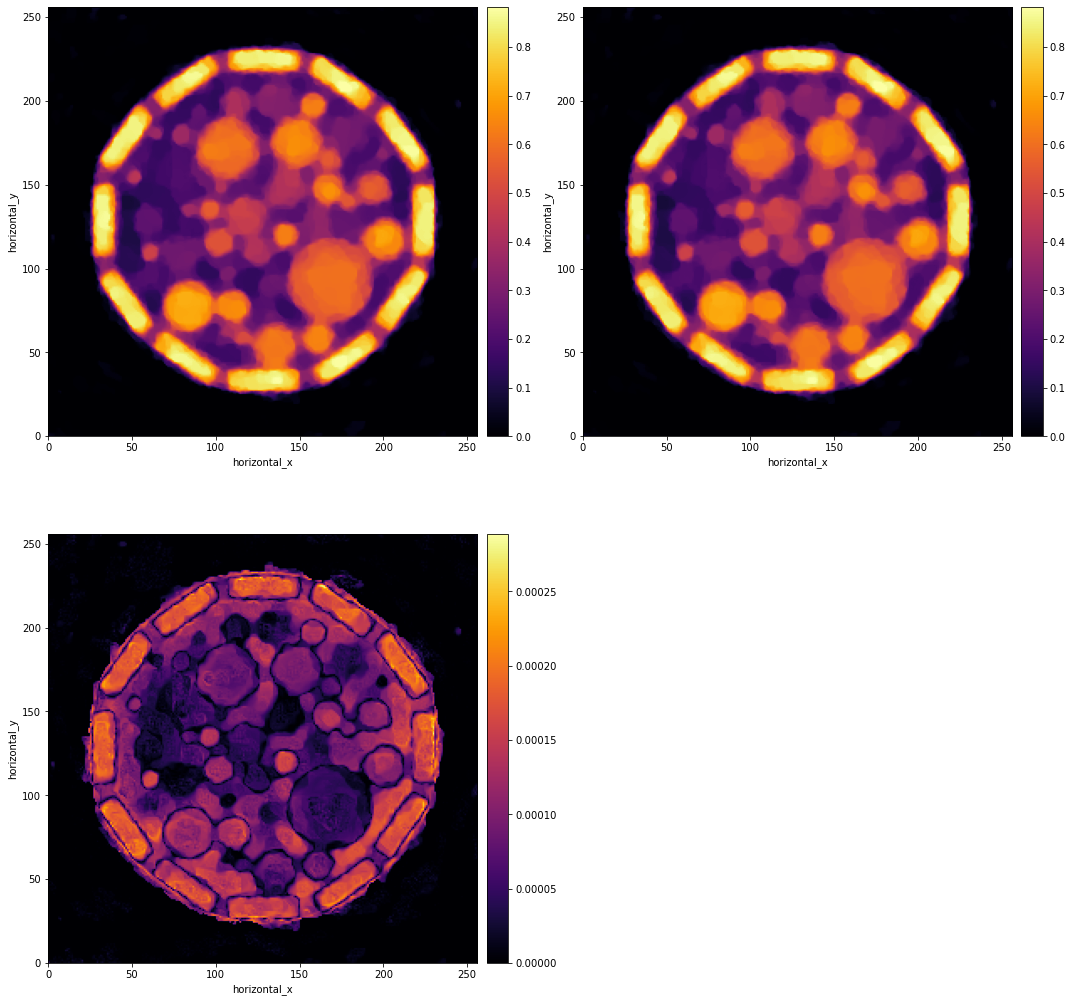

In [13]:
show2D([admm.solution, pdhg.solution, (admm.solution-pdhg.solution).abs()], cmap="inferno")

In [14]:
plotter2D([phantom2D, pdhg_explicit.solution, pdhg_implicit_cpu.solution,  pdhg_implicit_gpu.solution],
          title=["Phantom", "PDHG (explicit)", "PDHG (implicit-cpu) ", "PDHG (implicit-gpu) "],
         origin = "upper", cmap="inferno")

NameError: name 'plotter2D' is not defined

In [ ]:
# fidelity

# import libraries

import numpy as np

from cil.optimisation.algorithms import LADMM, PDHG
from cil.optimisation.functions import KullbackLeibler, L2NormSquared, L1Norm, MixedL21Norm, BlockFunction, ZeroFunction, IndicatorBox, TotalVariation
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator
from cil.framework import ImageGeometry, AcquisitionGeometry
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.display import plotter2D
from cil.plugins.ccpi_regularisation.functions import FGP_TV 

import os, sys

import tomophantom
from tomophantom import TomoP2D

import warnings

import matplotlib.pyplot as plt

In [ ]:
def new_proximal(self, x, tau, out=None):
    
    if out is None:        
        
        return 0.5 * ( (x - self.eta - tau) + ( (x + self.eta - tau).power(2) + 4*tau*self.b ) .sqrt() )

    else:
        
        warnings.warn("{}: the __call__ method is not currently implemented. Returning 0.".format(self.__class__.__name__))
        
        return 0.0
        
        
#         tmp = 0.5 * ( (x - self.eta - tau) + ( (x + self.eta - tau).power(2) + 4*tau*self.b ) .sqrt() )
#         out.fill(tmp)
        
        out = x*0.
        x.add(self.eta, out=out)
        out -= tau
        out *= out
        out.add(self.b * (4 * tau), out=out)
        out.sqrt(out=out)  
        out.subtract(tau, out=out)
        out.subtract(self.eta, out=out)
        out.add(x, out=out)         
        out *= 0.5  
        

        
       

          
        
def new_proximal_conjugate(self, x, tau, out=None):
    
    if out is None:
        z = x + tau * self.eta
        return 0.5*((z + 1) - ((z-1).power(2) + 4 * tau * self.b).sqrt())
    else:
        
# if out is None:
#                 z = x + tau * self.eta
#                 return 0.5*((z + 1) - ((z-1).power(2) + 4 * tau * self.b).sqrt())
#             else:            
#                 tmp = tau * self.eta
#                 tmp += x
#                 tmp -= 1
                
#                 self.b.multiply(4*tau, out=out)    
                
#                 out.add(tmp.power(2), out=out)
#                 out.sqrt(out=out)
#                 out *= -1
#                 tmp += 2
#                 out += tmp
#                 out *= 0.5        
        
        z = x + tau * self.eta
        tmp = 0.5*((z + 1) - ((z-1).power(2) + 4 * tau * self.b).sqrt())
        out.fill(tmp)
        
                
# KullbackLeibler.proximal = new_proximal
# KullbackLeibler.proximal_conjugate = new_proximal_conjugate

In [ ]:
# Load a tomophantom image 
model = 12 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.5, voxel_size_y = 0.5)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np+1)

In [ ]:
noise = "poisson"

alpha = 0.2

if noise == 's&p':
    f2 = L1Norm(b=phantom2D)  
elif noise == 'poisson':
    f2 = KullbackLeibler(b=phantom2D, eta=ig.allocate(0))
elif noise == 'gaussian':
    f2 = 0.5*L2NormSquared(b=phantom2D)

#setup and run ADMM            

operator = GradientOperator(ig)       
g = alpha * MixedL21Norm()

opnorm = operator.norm()
sigma = opnorm
tau = 1./opnorm

# Setup and run the PDHG algorithm
admm = LADMM(f = f2, g = g, operator = operator, sigma = sigma, tau = tau)
admm.max_iteration = 3000
admm.update_objective_interval = 500
admm.run(1000, verbose=True)   

In [ ]:
# Setup and run the PDHG algorithm
# Note here we use the proximal conjugate of the KL divergence

# Create operators
op1 = GradientOperator(ig)
op2 = IdentityOperator(ig, ig)

# Create BlockOperator
operator = BlockOperator(op1, op2, shape=(2,1) ) 

# Create functions      
f = BlockFunction(g, f2) 
h = IndicatorBox(lower=0)

sigma = 1
tau = 1/(sigma * operator.norm()**2 )

# Setup and run the PDHG algorithm
pdhg = PDHG(f = f, g = h, operator=operator)
pdhg.max_iteration = 3000
pdhg.update_objective_interval = 500
pdhg.run(1000, very_verbose = True)    

In [ ]:
# Show results
plt.figure(figsize=(8,10))
plt.subplot(2,2,1)
plt.imshow(phantom2D.as_array())
plt.title('Ground Truth')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(phantom2D.as_array())
plt.title('Noisy Data')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(admm.get_output().as_array())
plt.title('ADMM: TV Reconstruction')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(pdhg.get_output().as_array())
plt.title('PDHG: TV Reconstruction')
plt.colorbar() 
plt.show()

plt.figure(figsize=(10,5))            
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), phantom2D.as_array()[int(ig.shape[0]/2),:], label = 'GTruth')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), admm.get_output().as_array()[int(ig.shape[0]/2),:], label = 'ADMM reconstruction')
plt.plot(np.linspace(0,ig.shape[1],ig.shape[1]), pdhg.get_output().as_array()[int(ig.shape[0]/2),:], label = 'PDHG reconstruction')

plt.legend()
plt.title('Middle Line Profiles')
plt.show()